# Assignment 2
###Import the Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import pandas as pd
from datetime import datetime
import dateutil
import ast
from wordcloud import WordCloud

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"happydatasb","key":"c80e18fc19f9a7bfb58312fc91f7eee7"}'}

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

In [ ]:
!kaggle datasets download -d shuyangli94/food-com-recipes-and-user-interactions
!unzip food-com-recipes-and-user-interactions.zip -d /content/

Dataset URL: https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions
License(s): copyright-authors
 95% 255M/267M [00:01<00:00, 183MB/s]
100% 267M/267M [00:01<00:00, 195MB/s]
Archive:  food-com-recipes-and-user-interactions.zip
  inflating: /content/PP_recipes.csv  
  inflating: /content/PP_users.csv   
  inflating: /content/RAW_interactions.csv  
  inflating: /content/RAW_recipes.csv  
  inflating: /content/ingr_map.pkl   
  inflating: /content/interactions_test.csv  
  inflating: /content/interactions_train.csv  
  inflating: /content/interactions_validation.csv  


In [ ]:
# Read in the main RAW_Interactions File
def readFileIn(path):
    data = []
    with open(path, 'r', errors = "ignore") as file:
        csv_reader = csv.reader(file)
        for d in csv_reader:
            if d[0] == "user_id":
                continue
            data.append((d[0], d[1], d[2], d[3], d[4]))

    return data

data = readFileIn('RAW_interactions.csv')

### Interactions Format: [user_id, recipe_id, date, rating, review]

# Read in RAW_Recipes file
def readRecipesIn(path):
    return pd.read_csv(path)

recipes = readRecipesIn("RAW_recipes.csv")

In [ ]:
## Recipes Formats
print(recipes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB
None


### General Statistics

In this section, we perform exploratory data analysis on our dataset.

In [ ]:
### Basic Information
data_df = pd.DataFrame({"user_id": [d[0] for d in data],
        "recipe_id": [d[1] for d in data],
        "date": [d[2] for d in data],
        "rating": [int(d[3]) for d in data],
        "review": [d[4] for d in data]}
    )

## User and Recipe Count

def userCount(df):
    return df["user_id"].nunique()

def recipeCount(df):
    return df["recipe_id"].nunique()

nUsers = userCount(data_df)
nRecipes = recipeCount(data_df)

print("# of Users: " + str(nUsers) + "\n")
print("# of Recipes: " + str(nRecipes) + "\n")
print("# of Reviews: " + str(len(data)) + "\n")

## Data Sparsity
nInteractions = data_df.shape[0] # the number of interactions in the dataset

maxPossibleInteractions = nUsers * nRecipes # the maxmimum interactions that could exist from this dataset

sparsity = 1 - (nInteractions / maxPossibleInteractions)

print("Data Sparsity: " + str(round(sparsity, 5)) + "\n")
# this means the subset of recipes the users have interacted with is quite small compared to total number of recipes. Helps us justify using SVD or other dimensionality reducing techniques

## Oldest and Newest Review

convert_dates = [datetime.strptime(date, "%Y-%m-%d") for date in data_df["date"]]
oldest = str(min(convert_dates)).split()
newest = str(max(convert_dates)).split()

print("Oldest Review: " + oldest[0] + "\n")
print("Newest Review: " + newest[0] + "\n")

## Recipe Ingredients Stats

nIngredientsAvg = round(recipes["n_ingredients"].mean(), 3)
stdDevIngredients = round(recipes["n_ingredients"].std(), 3)

print("Average # of Ingredients: " + str(nIngredientsAvg) + "\n")
print("Standard Deviation of # of Ingredients: " + str(stdDevIngredients) + "\n")

## Average Cooking Time

averageTime = round(recipes["minutes"].mean(), 3)
stdDevTime = round(recipes["minutes"].std(), 3)

print("Average Time Per Recipe: " + str(averageTime) + "\n")
print("Standard Deviation of Time Per Recipe: " + str(stdDevTime) + "\n")

## Average Number of Steps

nStepsAvg = round(recipes["n_steps"].mean(), 3)
nStepsStdDev = round(recipes["n_steps"].std(), 3)

print("Average Steps Per Recipe: " + str(nStepsAvg) + "\n")
print("Standard Deviation of Steps Per Recipe: " + str(nStepsStdDev) + "\n")

## Recipe Tags

# get all the tags from each recipe
recipeTags = []
for d in recipes["tags"]:
    for tag in d.split(","):
        if tag not in recipeTags:
            recipeTags.append(tag)


# filter out extra characters in the tags
chars = set("[]'")
for index, value in enumerate(recipeTags):
    if any((c in chars) for c in value):
        for remove in "[]'":
            value = value.replace(remove, "")
        recipeTags[index] = value.strip()

print("# of Tags for Recipes: " + str(len(recipeTags)) + "\n")

# of Users: 226570

# of Recipes: 231637

# of Reviews: 1132367

Data Sparsity: 0.99998

Oldest Review: 2000-01-25

Newest Review: 2018-12-20

Average # of Ingredients: 9.051

Standard Deviation of # of Ingredients: 3.735

Average Time Per Recipe: 9398.546

Standard Deviation of Time Per Recipe: 4461963.039

Average Steps Per Recipe: 9.765

Standard Deviation of Steps Per Recipe: 5.995

# of Tags for Recipes: 903



In [ ]:
## Max Cooking Time and Recipe Associated
# Given that the average and std dev is so high I wanted to look at what was causing this

print(recipes.loc[recipes["minutes"].idxmax()])

# Either this is a mistake or someone made a recipe that takes about 4000 years to make might be worth excluding this and any other ridiculous recipes, i.e. set a limit for the # of minutes that would be reasonable for a recipe to have
# See "Recipe Time Distribution" cell for further analysis on this

name                                          no bake granola balls
id                                                           261647
minutes                                                  2147483647
contributor_id                                               464080
submitted                                                2007-10-26
tags              ['60-minutes-or-less', 'time-to-make', 'course...
nutrition               [330.3, 23.0, 110.0, 4.0, 15.0, 24.0, 15.0]
n_steps                                                           9
steps             ['preheat the oven to 350 degrees', 'spread oa...
description       healthy snacks that kids (and grown ups) will ...
ingredients       ['rolled oats', 'unsweetened dried shredded co...
n_ingredients                                                     8
Name: 144074, dtype: object


Rating Mean: 4.411

Ratings Standard Deviation: 1.265


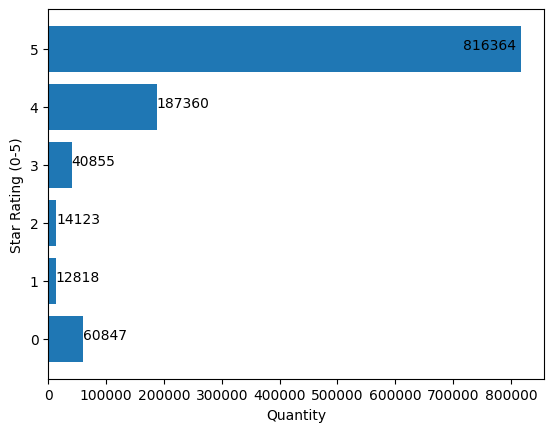

In [ ]:
### Rating Distribution

ratings = {}
for key in ['0', '1', '2', '3', '4', '5']:
    ratings[key] = 0

for d in data:
    ratings[d[3]] += 1

rating_keys = list(ratings.keys())
rating_values = list(ratings.values())
plt.barh(rating_keys, rating_values)
plt.xlabel("Quantity")
plt.ylabel("Star Rating (0-5)")

for index, value in enumerate(list(ratings.values())):
    if (index == 5):
        plt.text(value - 100000, index, str(value))
    else:
        plt.text(value, index, str(value))

### Rating Mean and Standard Deviation

ratingMean = 0
for key in list(ratings.keys()):
    ratingMean += int(key) * ratings[key]

ratingMean /= sum(list(ratings.values()))
ratingMean = round(ratingMean, 3)

ratings = [int(d[3]) for d in data]
ratingStdDev = round(np.std(ratings), 3)

print("Rating Mean: " + str(ratingMean) + "\n")
print("Ratings Standard Deviation: " + str(ratingStdDev))

As seen from figure, ratings are heavily left-skewed.

Text(0, 0.5, 'Recipe Time (minutes)')

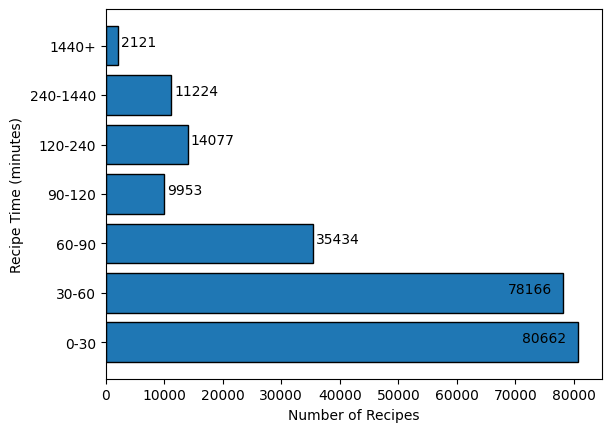

In [ ]:
## Recipe Time Distribution
bins = [0, 30, 60, 90, 120, 240, 1440, float('inf')]
recipeTimes = [int(currTime) for currTime in recipes["minutes"]]

bucket_counts = [sum(bins[i] <= time < bins[i+1] if bins[i+1] != float('inf') else bins[i] <= time for time in recipeTimes)
                 for i in range(len(bins) - 1)]

bucket_labels = [f"{int(bins[i])}-{int(bins[i+1])}" if bins[i+1] != float('inf') else f"{int(bins[i])}+" for i in range(len(bins) - 1)]

plt.clf()
plt.barh(bucket_labels, bucket_counts, edgecolor='black')

for index, value in enumerate(bucket_counts):
    if index == 0 or index == 1:
        plt.text(value - 9500, index, str(value))
    else:
        plt.text(value + 500, index, str(value))


plt.xlabel("Number of Recipes")
plt.ylabel("Recipe Time (minutes)")

# From this, we find that there are about 2121 recipes that take longer than 24 hours which we might want to remove

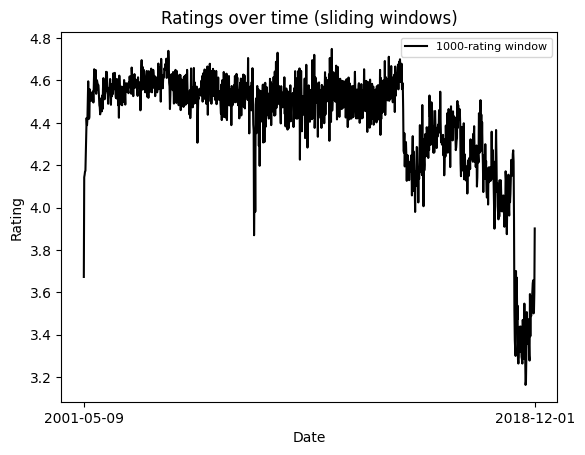

In [22]:
### Ratings vs Time Sliding Window

dateVals = [dataVal[2] for dataVal in data]
ratings = [dataVal[3] for dataVal in data]
dateUnix = []

def date_to_unix_timestamp(dateVal):
  date_obj = datetime.strptime(dateVal, "%Y-%m-%d")

  return int(date_obj.timestamp())

for dateVal in dateVals:
  dateUnix.append(date_to_unix_timestamp(dateVal))

ratingsTime=[]

for date, rating in zip(dateUnix, ratings):
    ratingsTime.append((date, rating))

ratingsTime.sort()

start_label = datetime.utcfromtimestamp(ratingsTime[0][0]).strftime('%Y-%m-%d')
end_label = datetime.utcfromtimestamp(ratingsTime[-1][0]).strftime('%Y-%m-%d')

wSize = 1000
#x = dateVals # as raw times
x = [dateutil.parser.parse(d) for d in dateVals]
xu = [r[0] for r in ratingsTime] # as unix times
y = [int(r[1]) for r in ratingsTime] # ratings

xSum = sum(xu[:wSize])
ySum = sum(y[:wSize])
sliding = []

for i in range(wSize,len(xu)):
    xSum += xu[i] - xu[i-wSize]
    ySum += y[i] - y[i-wSize]
    sliding.append((xSum*1.0/wSize,ySum*1.0/wSize))

X = [a[0] for a in sliding]
Y = [a[1] for a in sliding]


X_dates = [datetime.utcfromtimestamp(x).strftime('%Y-%m-%d') for x in X]

#plt.plot(X[:],Y[:], label="5000 rating window", color='k')
#plt.xticks([X[600], X[-350]], [x[wSize+600].strftime("%d/%m/%Y"), x[0].strftime("%d/%m/%Y")])
#plt.xlim(X[0], X[-1])
plt.plot(X_dates[::1000], Y[::1000], label=f"{wSize}-rating window", color='k')
plt.ylabel("Rating")
plt.xlabel("Date")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings over time (sliding windows)")
#plt.xticks([str(x[0]),str(x[-1])], visible=True)
start_label = X_dates[0]
end_label = X_dates[-1]
plt.xticks([X_dates[0], X_dates[-1]], [start_label, end_label])

plt.show()

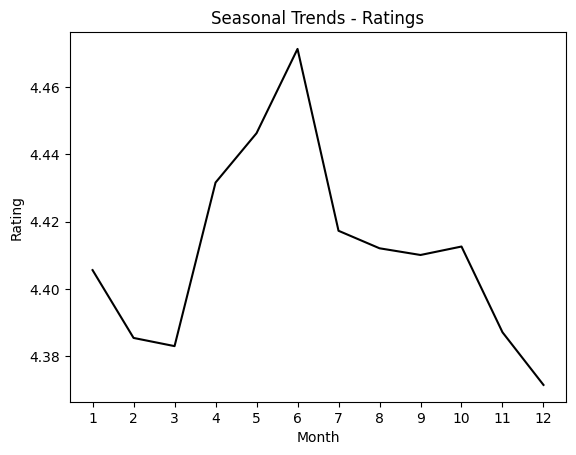

In [ ]:
### Ratings vs Month Sliding Window

ratingsTime = []

for date, rating in zip(dateVals, ratings):
    date = dateutil.parser.parse(date)
    date = int(str(date).split("-")[1])
    ratingsTime.append((date, int(rating))) # month

buckets = {}
buckets_avg = {}

for i in range(12):
  buckets[i + 1] = 0
  buckets_avg[i + 1] = 0

for month, rating in ratingsTime:
  buckets[month] += rating
  buckets_avg[month] += 1

for month in buckets:
  buckets[month] /= buckets_avg[month]

X = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Y = [buckets[i] for i in X]

plt.plot(X, Y, color='k')
plt.ylabel("Rating")
plt.xlabel("Month")
plt.xticks([X[0], X[1], X[2], X[3], X[4], X[5], X[6], X[7], X[8], X[9], X[10], X[-1]], X)
plt.title("Seasonal Trends - Ratings")

plt.show()

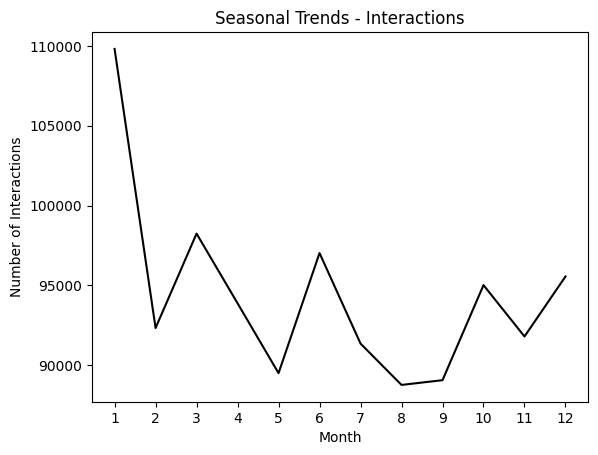

In [ ]:
### Ratings vs Month Sliding Window

ratingsTime = []

for date, rating in zip(dateVals, ratings):
    date = dateutil.parser.parse(date)
    date = int(str(date).split("-")[1])
    ratingsTime.append((date, int(rating)))

#start_label = datetime.utcfromtimestamp(ratingsTime[0][0]).strftime('%Y-%m-%d')
#end_label = datetime.utcfromtimestamp(ratingsTime[-1][0]).strftime('%Y-%m-%d')

buckets = {}
buckets_avg = {}

for i in range(12):
  buckets[i + 1] = 0
  buckets_avg[i + 1] = 0

for month, rating in ratingsTime:
  buckets[month] += rating
  buckets_avg[month] += 1

for month in buckets:
  buckets[month] /= buckets_avg[month]

X = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Y = [buckets_avg[i] for i in X]

plt.plot(X, Y, color='k')
plt.ylabel("Number of Interactions")
plt.xlabel("Month")
plt.xticks([X[0], X[1], X[2], X[3], X[4], X[5], X[6], X[7], X[8], X[9], X[10], X[-1]], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.title("Seasonal Trends - Interactions")

plt.show()

Tried analyzing popular ingredients by season next.

In [24]:
### Filter out Zero Ratings in Interactions

interactions_nozeroes = []

for d in data:
  if int(d[3]) != 0:
    interactions_nozeroes.append(d)

### Most Popular Ingredient by Season
"""
For reference:
Winter = ["December", "January", "February"]
Spring = ["March", "April", "May"]
Summer = ["June", "July", "August"]
Fall = ["September", "October", "November"]
"""

def readRecipeNormal(path):
    data = []
    with open(path, 'r', errors = "ignore") as file:
        csv_reader = csv.reader(file)
        for d in csv_reader:
            if d[0] == "name":
                continue
            data.append((d[0], d[1], d[2], d[3], d[4], d[5], d[6], d[7], d[8], d[9], d[10], d[11]))

    return data

recipes = readRecipeNormal("RAW_recipes.csv")
recipe_ids = [d[1] for d in recipes]

# recipes format = [name, id, minutes, contributor_id, submitted, tags, nutrition, n_steps, steps, description, ingredients, n_ingredients]
# Interactions Format: [user_id, recipe_id, date, rating, review]

# Get Ingredients for all Recipes and Pair with Month

data_ing_month = []

for d in data:
    date = dateutil.parser.parse(d[2])
    date = int(str(date).split("-")[1])

    recipeIdx = recipe_ids.index(d[1])
    currRecipeIngredients = ast.literal_eval(recipes[recipeIdx][10])

    data_ing_month.append((date, currRecipeIngredients))

winter = {}
spring = {}
summer = {}
fall = {}


for d in data_ing_month:
  if d[0] in [12, 1, 2]:
    for ing in d[1]:
      if ing in winter:
        winter[ing] += 1
      else:
        winter[ing] = 1
  elif d[0] in [3, 4, 5]:
    for ing in d[1]:
      if ing in spring:
        spring[ing] += 1
      else:
        spring[ing] = 1

  elif d[0] in [6, 7, 8]:
    for ing in d[1]:
      if ing in summer:
        summer[ing] += 1
      else:
        summer[ing] = 1

  elif d[0] in [9, 10, 11]:
    for ing in d[1]:
      if ing in fall:
        fall[ing] += 1
      else:
        fall[ing] = 1

# Most Popular Ingredient in Each Season
mostPopular_winter = max(winter, key=winter.get)
mostPopular_spring = max(spring, key=spring.get)
mostPopular_summer = max(summer, key=summer.get)
mostPopular_fall = max(fall, key=fall.get)

print(mostPopular_winter)
print(mostPopular_spring)
print(mostPopular_summer)
print(mostPopular_fall)


KeyboardInterrupt: 

In [ ]:
### Sort Ingredient Frequencies

sortedWinter = dict(sorted(winter.items(), key = lambda x:x[1], reverse=1))
sortedSpring = dict(sorted(spring.items(), key = lambda x:x[1], reverse=1))
sortedSummer = dict(sorted(summer.items(), key = lambda x:x[1], reverse=1))
sortedFall = dict(sorted(fall.items(), key = lambda x:x[1], reverse=1))

print(sortedWinter)
print(sortedSpring)
print(sortedSummer)
print(sortedFall)

In [ ]:
### Create Word Clouds for Seasons

# Winter
winter_wc = WordCloud().generate_from_frequencies(winter)
plt.imshow(winter_wc, interpolation="bilinear")
plt.axis("off")
print("Winter Word Cloud")
plt.show()

print("\n \n")

# Spring
spring_wc = WordCloud().generate_from_frequencies(spring)
plt.imshow(spring_wc, interpolation="bilinear")
plt.axis("off")
print("Spring Word Cloud")
plt.show()

print("\n \n")

# Summer
summer_wc = WordCloud().generate_from_frequencies(summer)
plt.imshow(summer_wc, interpolation="bilinear")
plt.axis("off")
print("Summer Word Cloud")
plt.show()

print("\n \n")


# Fall
fall_wc = WordCloud().generate_from_frequencies(fall)
plt.imshow(fall_wc, interpolation="bilinear")
plt.axis("off")
print("Fall Word Cloud")
plt.show()

Some recipes were rated 0 but reviews were positive. Out of curiosity, wanted to try using sentiment polarity to re-rate any recipes that were rated '0'.

In [25]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.7 MB/s eta 0:00:00


In [26]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [27]:
data = readFileIn('RAW_interactions.csv')
data_df = pd.DataFrame({"user_id": [d[0] for d in data],
        "recipe_id": [d[1] for d in data],
        "date": [d[2] for d in data],
        "rating": [int(d[3]) for d in data],
        "review": [d[4] for d in data]}
)

analyzer=SentimentIntensityAnalyzer()
def get_vader_sentiment_polarity(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

data_df['sentiment_polarity'] = data_df['review'].apply(get_vader_sentiment_polarity)


In [28]:
def adjust_rating(row):
    if row['rating'] == 0:
        if row['sentiment_polarity'] > 0.2:  # Positive sentiment
            return 4 if row['sentiment_polarity'] > 0.5 else 3
        elif row['sentiment_polarity'] < -0.2:  # Negative sentiment
            return 1
        else:  # Neutral sentiment
            return 2
    else:
        return row['rating']

In [29]:
# apply the rating adjustment
data_df['adjusted_rating'] = data_df.apply(adjust_rating, axis=1)
print(data_df[['review', 'rating', 'sentiment_polarity', 'adjusted_rating']])


                                                    review  rating  \
0        Great with a salad. Cooked on top of stove for...       4   
1        So simple, so delicious! Great for chilly fall...       5   
2        This worked very well and is EASY.  I used not...       4   
3        I made the Mexican topping and took it to bunk...       5   
4        Made the cheddar bacon topping, adding a sprin...       5   
...                                                    ...     ...   
1132362  Another approach is to start making sauce with...       0   
1132363  These were so delicious!  My husband and I tru...       5   
1132364  WOW!  Sometimes I don't take the time to rate ...       5   
1132365  Very good!  I used regular port as well.  The ...       4   
1132366  I am so glad I googled and found this here. Th...       5   

         sentiment_polarity  adjusted_rating  
0                    0.7184                4  
1                    0.8895                5  
2                 

In [30]:
import seaborn as sns

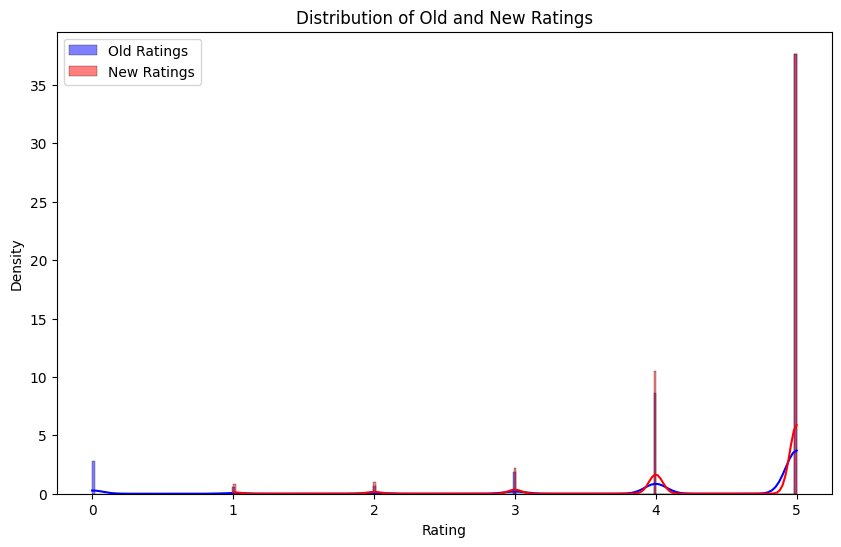

In [31]:
# Separate the old and new ratings
old_ratings = data_df['rating']
new_ratings = data_df['adjusted_rating']

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Plot the old ratings
sns.histplot(old_ratings, kde=True, color='blue', label='Old Ratings', stat='density')

# Plot the new ratings
sns.histplot(new_ratings, kde=True, color='red', label='New Ratings', stat='density')

# Add labels and title
plt.title('Distribution of Old and New Ratings')
plt.xlabel('Rating')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Baseline Models

This first one that we are going to explore is a popularity-based model.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import pandas as pd
from datetime import datetime
from collections import defaultdict
import random
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [33]:
from collections import defaultdict

train_len = int(0.9*len(data))

### Data Format: [user_id, recipe_id, date, rating, review]
# Splitting into training and validation sets based on all data
ratings_train = data[:train_len]
ratings_valid = data[train_len:]

ratings_per_user = defaultdict(set)
ratings_per_recipe = defaultdict(set)
ratingDict = {}

# Populating the dictionaries from the training data
for row in ratings_train:
    user = row[0]
    recipe = row[1]

    ratings_per_user[user].add(recipe)
    ratings_per_recipe[recipe].add(user)
    ratingDict[(user, recipe)] = row[3]

In [34]:
recipe_count = defaultdict(int)
total_cooked = 0

for row in data:
    recipe_count[row[1]] += 1  # Count the number of interactions per recipe
    total_cooked += 1            # Increment the total interactions count

global_popularity = total_cooked/len(recipe_count)

# Create a list of recipes sorted by popularity
most_popular = [(recipe_count[x], x) for x in recipe_count]
most_popular.sort(reverse=True)  # Sort by count in descending order

# Create a set of all unique recipes
all_recipes = set(recipe_count.keys())

In [36]:
import random
# Create validation set that denotes if the user has or has not used the recipe
def use_negatives(ratings, ratings_per_user, all_recipes):
    all_recipes_list=list(all_recipes)
    count=0
    with_negatives = []
    for row in ratings:
        user = row[0]
        recipe = row[1]
        with_negatives.append((user, recipe, 1))

        user_recipes = set(ratings_per_user[user])
        while True:
            negative_recipe = random.choice(all_recipes_list)
            if negative_recipe not in user_recipes:
                with_negatives.append((user, negative_recipe, 0))
                count+=1
                break
    return with_negatives

cooked_valid = use_negatives(ratings_valid, ratings_per_user, all_recipes)

In [37]:
# Baseline prediction of giving all the recipes a prediction of 0
correct = 0
for user, recipe, label in cooked_valid:
    if label==0:
        correct+=1

print(correct/len(cooked_valid))

0.5


In [38]:


best_popularity_accuracy = 0
best_popularity_threshold = 0

popularity_thresholds = np.arange(0.1, 1, 0.1)

for p in popularity_thresholds:
    return1 = set()
    count = 0
    threshold_count = total_cooked * p

    for ic, recipe in most_popular:
        count += ic
        return1.add(recipe)
        if count > threshold_count:
            break

    correct = 0
    for user, recipe, label in cooked_valid:
        prediction = 1 if recipe in return1 else 0
        if prediction == label:
            correct += 1

    accuracy = correct / len(cooked_valid)

    print(p, accuracy)
    if accuracy > best_popularity_accuracy:
        best_popularity_accuracy = accuracy
        best_popularity_threshold = p

print(f"Best Accuracy: {best_popularity_accuracy:.2f}, Best Threshold: {best_popularity_threshold:.2f}")

0.1 0.5459478792267545
0.2 0.5953972641451116
0.30000000000000004 0.6392963430680785
0.4 0.6770666831512668
0.5 0.7086332205904431
0.6 0.7312627498079249
0.7000000000000001 0.7401026166359053
0.8 0.7258007541704566
0.9 0.6703771735386843
Best Accuracy: 0.74, Best Threshold: 0.70


In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Variables to store true labels and predictions
true_labels = []
predictions = []

# Calculate the recipes to return using the best popularity threshold
return1 = set()
count = 0
threshold_count = total_cooked * 0.7

for ic, recipe in most_popular:
    count += ic
    return1.add(recipe)
    if count > threshold_count:
        break

# Generate predictions for the validation set
for user, recipe, label in cooked_valid:
    prediction = 1 if recipe in return1 else 0
    true_labels.append(label)
    predictions.append(prediction)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 0.76
Recall: 0.69
F1 Score: 0.73


### Jaccard Similarity Model

In [40]:
# Jaccard similarity
def Jaccard(r1, r2):
    u1 = ratings_per_recipe[r1]
    u2 = ratings_per_recipe[r2]
    if u1.union(u2) == 0:
        return 0
    return len(u1.intersection(u2)) / len(u1.union(u2))

In [ ]:
jaccard_accuracy = 0
best_jaccard_threshold = 0
jaccard_thresholds = np.arange(0.6, 0.9, 0.1)

for j in jaccard_thresholds:
    correct = 0
    for user, recipe, label in cooked_valid:
        max_jaccard = max((Jaccard(recipe, rprime) for rprime in ratings_per_user[user]),default=0)

        prediction=0
        if max_jaccard > j:
            prediction = 1
        else:
            prediction = 0

        if prediction == label:
            correct += 1

    accuracy = correct / len(cooked_valid)
    print(j, accuracy)

    if accuracy > jaccard_accuracy:
        best_jaccard_threshold = j
        jaccard_accuracy = accuracy

print(f"Best Accuracy: {jaccard_accuracy:.2f}, Best Threshold: {best_jaccard_threshold:.2f}")

# The best Jaccard threshold is no better than our baseline - as seen below, the best threshold is simply
# the one that assigns all recipes to 0

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Variables to store true labels and predictions
true_labels = []
predictions = []

# Using the best threshold from previous computation
for user, recipe, label in cooked_valid:
    max_jaccard = max((Jaccard(recipe, rprime) for rprime in ratings_per_user[user]), default=0)

    # Predict based on the best threshold
    prediction = 1 if max_jaccard > 0.7 else 0

    # Append true labels and predictions
    true_labels.append(label)
    predictions.append(prediction)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

### Cosine Similarity Model

In [ ]:
import math
# Cosine Similarity
def cosine_similarity(r1, r2):
    u1 = ratings_per_recipe[r1]
    u2 = ratings_per_recipe[r2]
    numer = len(u1.intersection(u2))
    denom = math.sqrt(len(u1)) * math.sqrt(len(u2))
    if denom == 0:
        return 0
    return numer / denom

In [ ]:
cosine_accuracy = 0
best_cosine_threshold = 0
cosine_thresholds = np.arange(0.8, 1, 0.1)

for c in cosine_thresholds:
    correct = 0
    for user, recipe, label in cooked_valid:
        max_cosine = max((cosine_similarity(recipe, rprime) for rprime in ratings_per_user[user]),default=0)

        prediction=0
        if max_cosine > c:
            prediction = 1
        else:
            prediction = 0

        if prediction == label:
            correct += 1

    accuracy = correct / len(cooked_valid)
    print(c, accuracy)

    if accuracy > cosine_accuracy:
        best_cosine_threshold = c
        cosine_accuracy = accuracy

print(f"Best Accuracy: {cosine_accuracy:.2f}, Best Threshold: {best_cosine_threshold:.2f}")

# The best Cosine threshold is no better than our baseline - as seen below, the best threshold is simply
# the one that assigns all recipes to 0

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Variables to store true labels and predictions
true_labels = []
predictions = []

# Using the best threshold from previous computation
for user, recipe, label in cooked_valid:
    max_cosine = max((cosine_similarity(recipe, rprime) for rprime in ratings_per_user[user]), default=0)

    # Predict based on the best threshold
    prediction = 1 if max_cosine > 0.9 else 0

    # Append true labels and predictions
    true_labels.append(label)
    predictions.append(prediction)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

### Logistic Regression Model

In [ ]:
# Logistic regression using only popularity metrics, since on their own,
# Cosine and Jaccard similarities were no better than the baseline

X_train = []
y_train = []

for user, recipe, label in cooked_valid:
    popularity_score = recipe_count[recipe] / global_popularity
    user_activity = len(ratings_per_user[user]) / total_cooked

    # add all features to feature vector
    features = [popularity_score, user_activity]
    X_train.append(features)
    y_train.append(label)


# Handle missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
X_train = imputer.fit_transform(X_train)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)

# Evaluate the model
y_pred = log_reg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
# Logistic regression using average Cosine and Jaccard similarities along with their
# weighted similarity

X_train = []
y_train = []

K_values = [2,4,6]  # average top-K similarities for jaccard and cosine, as suggested by chatgpt

for user, recipe, label in cooked_valid:
    jaccard_similarities = [Jaccard(recipe, r) for r in ratings_per_user[user]]
    jaccard_similarities.sort(reverse=True)
    avg_jaccard_features = [np.mean(jaccard_similarities[:K]) for K in K_values]

    cosine_similarities = [cosine_similarity(recipe, r) for r in ratings_per_user[user]]
    cosine_similarities.sort(reverse=True)
    avg_cosine_features = [np.mean(cosine_similarities[:K]) for K in K_values]

    popularity_score = recipe_count[recipe] / global_popularity
    user_activity = len(ratings_per_user[user]) / total_cooked
    weighted_similarity = 0.5 * avg_jaccard_features[0] + 0.5 * avg_cosine_features[0]
    # add all features to feature vector
    features = avg_jaccard_features + avg_cosine_features + [popularity_score, user_activity, weighted_similarity]
    X_train.append(features)
    y_train.append(label)

imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
X_train = imputer.fit_transform(X_train)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)

y_pred = log_reg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
# Validation Metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.calibration import calibration_curve

precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

In [ ]:
# Balanced class weight makes no difference
log_reg_model = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg_model.fit(X_train, y_train)

y_pred = log_reg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.calibration import calibration_curve

precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

### SVD Model

This model will predict user ratings for a recipe.

In [ ]:
!pip install surprise

In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split


In [ ]:
data = pd.DataFrame(data,columns=["user_id","recipe_id","date","rating","review"])

reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(data[['user_id','recipe_id','rating']],reader)

train_data, val_data = train_test_split(data, test_size=0.2)

In [ ]:
svd_model=SVD()
svd_model.fit(train_data)
predictions = svd_model.test(val_data)

In [ ]:
# just to visualize some predictions, check if it has data
for prediction in predictions[:5]:
    print(f"User {prediction.uid} predicted rating for item {prediction.iid}: {prediction.est}")

In [ ]:
# MSE for model predictions
sse = 0
for p in predictions:
    sse += (p.r_ui - p.est)**2

print(sse / len(predictions))

MSE not that great, so going to optimize model a bit.

In [ ]:
from surprise.model_selection import RandomizedSearchCV
from surprise import accuracy

In [ ]:
param_grid = {
    'n_factors': [25, 50, 75, 100],
    'n_epochs': [20, 25, 30, 50],
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.2, 0.5]
}

In [ ]:
rs = RandomizedSearchCV(SVD, param_grid, measures=['rmse'], cv=5,n_iter=10,n_jobs=-1, random_state=42)
rs.fit(data)
print("Best RMSE:", rs.best_score['rmse'])
print("Best parameters:", rs.best_params['rmse'])

In [ ]:
# Initialize the model with the best parameters
svd_model = SVD(n_factors=50, n_epochs=25, lr_all=0.005, reg_all=0.1)

svd_model.fit(train_data)
predictions = svd_model.test(val_data)

# calculate the RMSE on the predictions
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")
print(f"MSE: {rmse**2}")

# Content Based Filtering Model

In [ ]:
# Step 1: Import Required Libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

recipes = pd.read_csv('RAW_recipes.csv')

# Step 4: Preprocess Data
# Combine tags and ingredients into a searchable text column
recipes['tags'] = recipes['tags'].str.strip('[]').str.replace("'", "").str.replace(",", " ")
recipes['ingredients'] = recipes['ingredients'].str.strip('[]').str.replace("'", "").str.replace(",", " ")
recipes['searchable_text'] = recipes['tags'].fillna('') + ' ' + recipes['ingredients'].fillna('')

# Extract calories and time from the dataset
# Nutrition format: "[calories, fat, sugar, sodium, protein, saturated fat, ...]"
recipes['calories'] = recipes['nutrition'].str.strip('[]').str.split(',').str[0].astype(float)
recipes['time'] = recipes['minutes']
recipes['steps'] = recipes['steps'].str.strip('[]').str.replace("'", "")

# Step 5: Filter Recipes by Available Ingredients, Calories, and Time
def filter_recipes(recipes, available_ingredients, max_calories=None, max_time=None):
    # Filter by ingredients
    filtered = recipes[recipes['ingredients'].str.contains('|'.join(available_ingredients), case=False, na=False)]

    # Apply calorie filter if specified
    if max_calories is not None:
        filtered = filtered[filtered['calories'] <= max_calories]

    # Apply time filter if specified
    if max_time is not None:
        filtered = filtered[filtered['time'] <= max_time]

    return filtered

# Step 6: Create a TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(recipes['searchable_text'])

# Step 7: Define Recommendation Function
def recommend_recipes(available_ingredients, search_tags, max_calories=None, max_time=None, top_n=5):
    # Filter recipes based on user preferences
    filtered_recipes = filter_recipes(recipes, available_ingredients, max_calories, max_time)

    # Combine available ingredients and tags into a query string
    query = ' '.join(available_ingredients) + ' ' + ' '.join(search_tags)

    # Transform the query into the same TF-IDF space
    query_vector = tfidf.transform([query])

    # Calculate cosine similarity between query and filtered recipes
    filtered_tfidf_matrix = tfidf.transform(filtered_recipes['searchable_text'])
    similarity_scores = cosine_similarity(query_vector, filtered_tfidf_matrix).flatten()

    # Rank recipes by similarity score
    top_indices = similarity_scores.argsort()[-top_n:][::-1]

    # Get recommended recipes
    recommended_recipes = filtered_recipes.iloc[top_indices]
    return recommended_recipes[['name', 'ingredients', 'tags', 'calories', 'time', 'steps']]


In [ ]:
# Example Usage
# Specify available ingredients, search tags, and (optional) user preferences
available_ingredients = ['chocolate', 'peanut butter', 'caramel']
search_tags = ['gluten free', 'easy']

# Specify optional filters
max_calories = None  # Leave as None if not required
max_time = 30  # Leave as None if not required

# Get Recommendations
recommendations = recommend_recipes(available_ingredients, search_tags, max_calories, max_time)
print("Recommended Recipes:")
for idx, row in recommendations.iterrows():
    print(f"\nRecipe Name: {row['name']}")
    print(f"Ingredients: {row['ingredients']}")
    print(f"Tags: {row['tags']}")
    print(f"Calories: {row['calories']}")
    print(f"Time to Cook: {row['time']} minutes")
    print(f"Steps: {row['steps']}")
    print("-" * 40)


# Hybrid Models

### Logistic Regression on Filtered Recipes

In [ ]:
# Perform similarities on recipes that contain chocolate (filtered dataset)

# Specify available ingredients
available_ingredients = ['chocolate']

# Specify optional filters
max_calories = None  # Leave as None if not required
max_time = None  # Leave as None if not required

# Filter recipes using content-based criteria
filtered_recipes = filter_recipes(recipes, available_ingredients, max_calories, max_time)

# Extract the IDs of the filtered recipes
filtered_recipe_ids = set(filtered_recipes['id'])

# Filter interactions based on the filtered recipes
filtered_ratings_train = [
    row for row in ratings_train if int(row[1]) in filtered_recipe_ids
]
filtered_ratings_valid = [
    row for row in ratings_valid if int(row[1]) in filtered_recipe_ids
]

# Update user and recipe dictionaries for filtered dataset
filtered_ratings_per_user = defaultdict(set)
filtered_ratings_per_recipe = defaultdict(set)
filtered_ratingDict = {}

for row in filtered_ratings_train:
    user = row[0]
    recipe = row[1]
    filtered_ratings_per_user[user].add(recipe)
    filtered_ratings_per_recipe[recipe].add(user)
    filtered_ratingDict[(user, recipe)] = row[3]

# Define cooked_valid for filtered recipes
filtered_cooked_valid = use_negatives(
    filtered_ratings_valid, filtered_ratings_per_user, filtered_recipe_ids
)

In [ ]:
filtered_recipe_count = defaultdict(int)
filtered_total_cooked = 0

for row in filtered_ratings_train:
    filtered_recipe_count[row[1]] += 1  # Count the number of interactions per recipe
    filtered_total_cooked += 1            # Increment the total interactions count

for row in filtered_ratings_valid:
    filtered_recipe_count[row[1]] += 1  # Count the number of interactions per recipe
    filtered_total_cooked += 1            # Increment the total interactions count

filtered_popularity = filtered_total_cooked/len(filtered_recipe_count)

# Create a set of all unique recipes
all_filtered_recipes = set(recipe_count.keys())

In [ ]:
# jaccard and cosine similarities based on filtered dictionaries
def Jaccard(r1, r2):
    u1 = filtered_ratings_per_recipe[r1]
    u2 = filtered_ratings_per_recipe[r2]
    if u1.union(u2) == 0:
        return 0
    return len(u1.intersection(u2)) / len(u1.union(u2))

def cosine_similarity(r1, r2):
    u1 = filtered_ratings_per_recipe[r1]
    u2 = filtered_ratings_per_recipe[r2]
    numer = len(u1.intersection(u2))
    denom = math.sqrt(len(u1)) * math.sqrt(len(u2))
    if denom == 0:
        return 0
    return numer / denom

# Logistic regression on filtered dataset using combined features
filtered_X_train = []
filtered_y_train = []

for user, recipe, label in filtered_cooked_valid:
    jaccard_similarities = [Jaccard(recipe, r) for r in filtered_ratings_per_user[user]]
    jaccard_similarities.sort(reverse=True)
    avg_jaccard_features = [np.mean(jaccard_similarities[:K]) for K in K_values]

    cosine_similarities = [cosine_similarity(recipe, r) for r in filtered_ratings_per_user[user]]
    cosine_similarities.sort(reverse=True)
    avg_cosine_features = [np.mean(cosine_similarities[:K]) for K in K_values]

    popularity_score = recipe_count.get(recipe, 0) / filtered_popularity
    user_activity = len(filtered_ratings_per_user[user]) / filtered_total_cooked
    weighted_similarity = 0.5 * avg_jaccard_features[0] + 0.5 * avg_cosine_features[0]

    # Add all features to feature vector
    features = avg_jaccard_features + avg_cosine_features + [popularity_score, user_activity, weighted_similarity]
    filtered_X_train.append(features)
    filtered_y_train.append(label)

# Handle missing values
filtered_X_train = imputer.fit_transform(filtered_X_train)

# Normalize features
filtered_X_train = scaler.fit_transform(filtered_X_train)

# Split into training and test sets
filtered_X_train, filtered_X_test, filtered_y_train, filtered_y_test = train_test_split(filtered_X_train, filtered_y_train, test_size=0.2, random_state=42)

log_reg_model_filtered = LogisticRegression(max_iter=1000)
log_reg_model_filtered.fit(filtered_X_train, filtered_y_train)

filtered_y_pred = log_reg_model_filtered.predict(filtered_X_test)
filtered_accuracy = accuracy_score(filtered_y_test, filtered_y_pred)
print(f"Filtered Dataset Logistic Regression Accuracy: {filtered_accuracy:.2f}")

In [ ]:
# Validation Metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.calibration import calibration_curve

precision = precision_score(filtered_y_test, filtered_y_pred)
print(f"Precision: {precision:.2f}")

recall = recall_score(filtered_y_test, filtered_y_pred)
print(f"Recall: {recall:.2f}")

f1 = f1_score(filtered_y_test, filtered_y_pred)
print(f"F1 Score: {f1:.2f}")

### Applying SVD model on Content-Base Filtered Recipes

In [ ]:
def recommend_recipes(available_ingredients, search_tags, max_calories=None, max_time=None, top_n=5):
    filtered_recipes = filter_recipes(recipes, available_ingredients, max_calories, max_time)

    query = ' '.join(available_ingredients) + ' ' + ' '.join(search_tags)
    query_vector = tfidf.transform([query])

    filtered_tfidf_matrix = tfidf.transform(filtered_recipes['searchable_text'])
    similarity_scores = cosine_similarity(query_vector, filtered_tfidf_matrix).flatten()
    # print(len(similarity_scores))

    # Rank recipes by similarity score
    top_indices = similarity_scores.argsort()[-top_n:][::-1]

    # Select top filtered recipes and corresponding similarity scores
    top_filtered_recipes = filtered_recipes.iloc[top_indices]
    top_similarity_scores = similarity_scores[top_indices]

    # Return filtered recipes and their aligned similarity scores
    return top_filtered_recipes, top_similarity_scores


In [ ]:
# Step 1: Get content-based recommendations
available_ingredients = ['chocolate', 'peanut butter', 'caramel']
search_tags = ['60-minutes-or-less', 'easy']
filtered_recipes, similarity_scores = recommend_recipes(available_ingredients, search_tags)


# Step 2: Get collaborative filtering (SVD) predictions
user_id = "226867"
recipe_ids = filtered_recipes['id'].tolist()

# user_pred = [prediction for prediction in predictions if prediction.uid == user_id] #just to print svd pred for particular user to see what it has rated previously
# for prediction in user_pred:
#     print(f"User {prediction.uid} predicted rating for item {prediction.iid}: {prediction.est}")

svd_predictions = [svd_model.predict(user_id, recipe_id) for recipe_id in recipe_ids]


# Step 3: Combine content-based and collaborative filtering scores
combined_scores = pd.DataFrame({
    'recipe': filtered_recipes['name'],
    'recipe_id': filtered_recipes['id'],
    'content_score': similarity_scores
})

combined_scores['svd_predicted_rating'] = [pred.est for pred in svd_predictions]


# Step 4: Calculate the final hybrid score
combined_scores['final_score'] = combined_scores['content_score'] * 0.5 + combined_scores['svd_predicted_rating'] * 0.5


# Step 5: Sort by the final score and recommend top N recipes
top_recommended = combined_scores.sort_values(by='final_score', ascending=False).head(5)

# Display the top recommended recipes
pd.set_option('display.max_columns', None)
pd.set_option('display.width',1000)
pd.set_option('display.max_colwidth',None)
print(top_recommended[['recipe', 'recipe_id','content_score', 'svd_predicted_rating', 'final_score']])

In [ ]:
def precision_at_n(predictions,n=5,threshold=4.0):
  precision=[]

  for user_id,group in predictions.groupby('user_id'):
    top_n_pred = group.sort_values(by='predicted_rating',ascending=False).head(n)
    rec_relevant = top_n_pred[top_n_pred['actual_rating']>= threshold]

    precision.append(len(rec_relevant)/n)


  avg_precision = sum(precision)/len(precision)
  return avg_precision

In [ ]:
user_ids_to_filter = ["226867", "869184", "588889","128473","1663823","956104"]
raw_data = data.raw_ratings
ratings_df = pd.DataFrame(raw_data, columns=['user_id', 'recipe_id', 'rating','timestamp'])
filtered_data = ratings_df[ratings_df['user_id'].isin(user_ids_to_filter)]


predicted_scores = [svd_model.predict(user_id, recipe_id).est for user_id, recipe_id in zip(filtered_data['user_id'], filtered_data['recipe_id'])]


# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'user_id': filtered_data['user_id'].tolist(),
    'recipe_id': filtered_data['recipe_id'].tolist(),
    'actual_rating': filtered_data['rating'].tolist(),
    'predicted_rating': predicted_scores  # Add your predicted ratings here
})
print(predictions_df)

avg_prec = precision_at_n(predictions_df)
print(f"Precision@5: {avg_prec:.4f}")

In [ ]:
avg_prec = precision_at_n(predictions_df)
print(f"Precision@5: {avg_prec:.4f}")